<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Spark-PCA" data-toc-modified-id="Spark-PCA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Spark PCA</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession 
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

# create the SparkSession class,
# which is the entry point into all functionality in Spark
# The .master part sets it to run on all cores on local, note
# that we should leave out the .master part if we're actually
# running the job on a cluster, or else we won't be actually
# using the cluster
spark = (SparkSession.
         builder.
         master('local[*]').
         appName('PCA').
         config(conf = SparkConf()).
         getOrCreate())

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn,pyspark

Ethen 2017-10-07 14:50:59 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.3
pandas 0.20.3
matplotlib 2.0.0
sklearn 0.19.0
pyspark 2.2.0


# Spark PCA

This is simply an API walkthough, for more details on PCA consider referring to the following [documentation](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/dim_reduct/PCA.ipynb).

In [3]:
# load the data and convert it to a pandas DataFrame,
# then use that to create the spark DataFrame
iris = load_iris()
X = iris['data']
y = iris['target']

data = pd.DataFrame(X, columns = iris.feature_names)
dataset = spark.createDataFrame(data, iris.feature_names)
dataset.show(6)

+-----------------+----------------+-----------------+----------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|
+-----------------+----------------+-----------------+----------------+
|              5.1|             3.5|              1.4|             0.2|
|              4.9|             3.0|              1.4|             0.2|
|              4.7|             3.2|              1.3|             0.2|
|              4.6|             3.1|              1.5|             0.2|
|              5.0|             3.6|              1.4|             0.2|
|              5.4|             3.9|              1.7|             0.4|
+-----------------+----------------+-----------------+----------------+
only showing top 6 rows



Next, in order to train ML models in Spark later, we'll use the `VectorAssembler` to combine a given list of columns into a single vector column.

In [4]:
# specify the input columns' name and
# the combined output column's name
assembler = VectorAssembler(
    inputCols = iris.feature_names, outputCol = 'features')

# use it to transform the dataset and select just
# the output column
df = assembler.transform(dataset).select('features')
df.show(6)

+-----------------+
|         features|
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|
+-----------------+
only showing top 6 rows



Next, we standardize the features, notice here we only need to specify the assembled column as the input feature.

In [5]:
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(df)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(df)
df_scaled.show(6)

+-----------------+--------------------+
|         features|      scaledFeatures|
+-----------------+--------------------+
|[5.1,3.5,1.4,0.2]|[-0.8976738791967...|
|[4.9,3.0,1.4,0.2]|[-1.1392004834649...|
|[4.7,3.2,1.3,0.2]|[-1.3807270877331...|
|[4.6,3.1,1.5,0.2]|[-1.5014903898672...|
|[5.0,3.6,1.4,0.2]|[-1.0184371813308...|
|[5.4,3.9,1.7,0.4]|[-0.5353839727944...|
+-----------------+--------------------+
only showing top 6 rows



After the preprocessing step, we fit the PCA model.

In [6]:
n_components = 2
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())
df_pca.show(6)

Explained Variance Ratio [ 0.72770452  0.23030523]
+-----------------+--------------------+--------------------+
|         features|      scaledFeatures|         pcaFeatures|
+-----------------+--------------------+--------------------+
|[5.1,3.5,1.4,0.2]|[-0.8976738791967...|[2.25698063306802...|
|[4.9,3.0,1.4,0.2]|[-1.1392004834649...|[2.07945911889540...|
|[4.7,3.2,1.3,0.2]|[-1.3807270877331...|[2.36004408158420...|
|[4.6,3.1,1.5,0.2]|[-1.5014903898672...|[2.29650366000388...|
|[5.0,3.6,1.4,0.2]|[-1.0184371813308...|[2.38080158645274...|
|[5.4,3.9,1.7,0.4]|[-0.5353839727944...|[2.06362347633723...|
+-----------------+--------------------+--------------------+
only showing top 6 rows



Notice that unlike scikit-learn, we use `transform` on the dataframe at hand for all ML models' class after fitting it (calling `.fit` on the dataframe). This will return the result in a new column, where the name is specified by the `outputCol` argument in the ML models' class.

We can convert it back to a numpy array by extracting the `pcaFeatures` column from each row, and use `collect` to bring the entire dataset back to a single machine.

In [7]:
# not sure if this is the best way to do it
X_pca = df_pca.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

In [8]:
# change default style figure and font size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12


def plot_iris_pca(X_pca, y):
    """a scatter plot of the 2-dimensional iris data"""
    markers = 's', 'x', 'o'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()

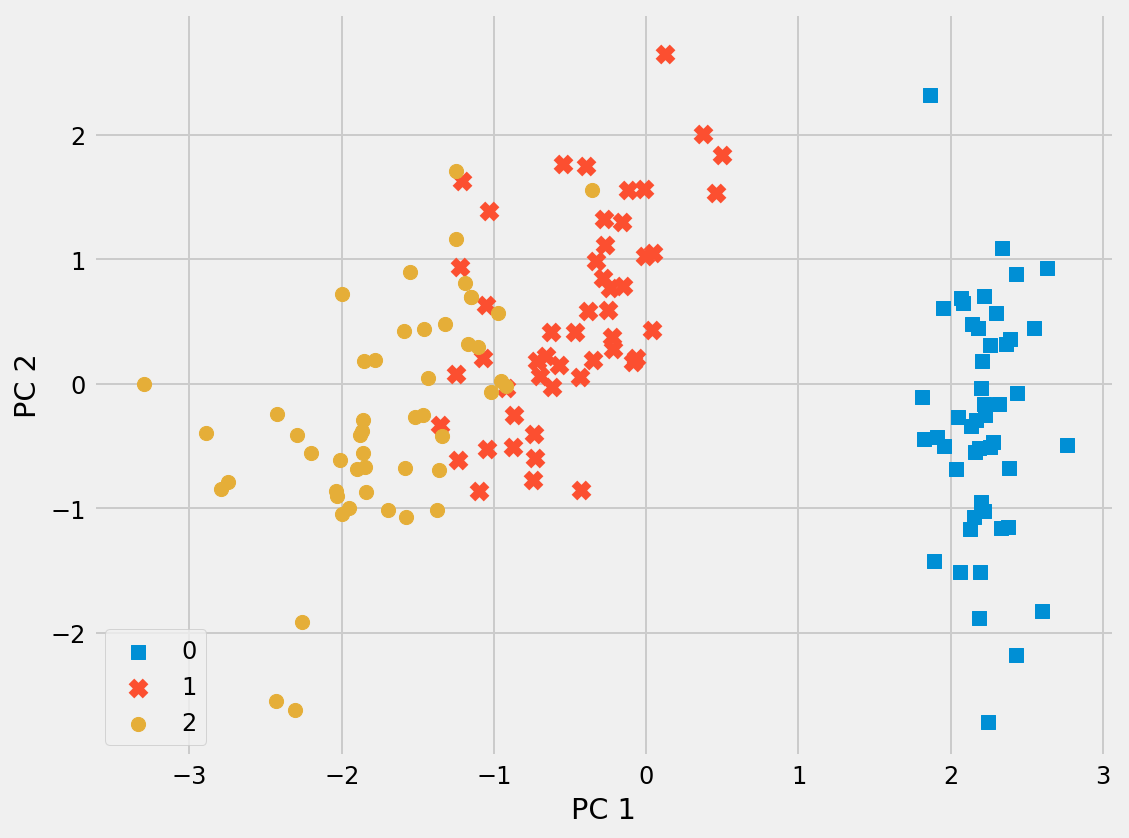

In [9]:
plot_iris_pca(X_pca, y)

In [10]:
# stop the current sparkSession
spark.stop()

# Reference

- [Tutorial: Introduction to Spark](http://people.duke.edu/~ccc14/sta-663-2016/21A_Introduction_To_Spark.html)
- [Spark Documentation: Spark SQL, DataFrames and Datasets Guide](http://spark.apache.org/docs/latest/sql-programming-guide.html)